**Examples**

Torque

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

Downloaded modsim.py


In [2]:
from modsim import *

Teapots and Turntables

In [3]:
from numpy import pi
cents_circ = 0.75
mass_circ = 10
cents_pot = 0.8
mass_pot = 0.4
force = 5
theta_push = 1.5
theta_test = 2.5
theta_target = pi
I_circ = mass_circ * cents_circ**2 / 4
I_pot = mass_pot * cents_pot**3
I_total = I_circ + I_pot
torque_friction = 0.5
init = State(theta=0, omega=0)
system = System(init=init,
                force=force,
                torque_friction=torque_friction,
                t_end=10)

In [4]:
def slope_func(t, state, system):
    theta, omega = state
    force = system.force
    torque_friction = system.torque_friction
    torque = cents_circ * force - torque_friction
    alpha = torque / I_total
    return omega, alpha
slope_func(0, system.init, system)

(0, 2.0173178982651065)

Two Phase Simulation

Phase 1

In [5]:
def event_func1(t, state, system):
    theta, omega = state
    return theta - theta_push
event_func1(0, system.init, system)
results1, details1 = run_solve_ivp(system, slope_func, events=event_func1)
details1.message

'A termination event occurred.'

In [6]:
results1.tail()

,theta,omega
1.170697,1.38240,2.361669
1.182892,1.41135,2.386270
1.195087,1.44060,2.410870
1.207282,1.47015,2.435471
1.219477,1.50000,2.460072


In [7]:
t_2 = results1.index[-1]
init2 = results1.iloc[-1]

Phase 2

In [8]:
systemb = system.set(t_0=t_2, init=init2, force=0)
def event_func2(t, state, system):
    theta, omega = state
    return omega
event_func2(systemb.t_0, systemb.init, systemb)
results2, details2 = run_solve_ivp(systemb, slope_func, events=event_func2)
details2.message

'A termination event occurred.'

Combining the Results

In [9]:
results = pd.concat([results1, results2])
results.tail()

,theta,omega
8.829010,11.234400,0.098403
8.908276,11.241225,0.073802
8.987542,11.246100,0.049201
9.066808,11.249025,0.024601
9.146074,11.250000,0.000000


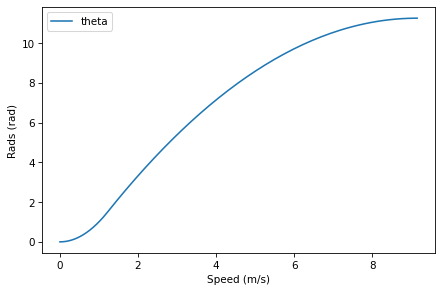

In [10]:
results.theta.plot(label='theta')
decorate(xlabel='Speed (m/s)', ylabel='Rads (rad)')

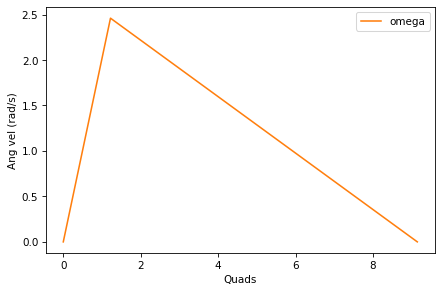

In [11]:
results.omega.plot(label='omega', color='C1')
decorate(xlabel='Quads', ylabel='Ang vel (rad/s)')

Estimating Friction

In [12]:
def run_two_phases(force, torque_friction, system):

    # put the specified parameters into the System object
    system1 = system.set(force=force, torque_friction=torque_friction)

    # run phase 1
    results1, details1 = run_solve_ivp(system1, slope_func, events=event_func1)

    # get the final state from phase 1
    t_2 = results1.index[-1]
    init2 = results1.iloc[-1]

    # run phase 2
    systemb = system1.set(t_0=t_2, init=init2, force=0)
    results2, details2 = run_solve_ivp(systemb, slope_func, events=event_func2)

    # combine and return the results
    results = pd.concat([results1, results2])
    return results
force = 2
torque_friction = 0.3
results = run_two_phases(force, torque_friction, system)
results.tail()

,theta,omega
9.680276,7.488319,0.065956
9.760207,7.492996,0.051072
9.840138,7.496484,0.036188
9.920069,7.498781,0.021303
10.000000,7.499889,0.006419


In [43]:
def error_func1(torque_friction, system):
    force = system.force
    results = run_two_phases(force, torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(torque_friction, theta_final)
    return theta_final - theta_test
guessa = 10
error_func1(guessa, system)

10 -193.97287483318306


-196.47287483318306

In [44]:
guessb = -10
error_func1(guessb, system)

-10 323.7477296661034


321.2477296661034

In [45]:
res = root_scalar(error_func1, system, bracket=[guessa, guessb])
actual_friction = res.root
actual_friction

10 -193.97287483318306
10.0 -193.97287483318306
-10.0 323.7477296661034
2.4100809152379856 2.333946534506522
2.4036640152707953 2.340177314409847
2.239149104880174 2.5121149760596304
2.2507410631615095 2.4991768675952573
2.2500035738660635 2.4999960290440155
2.24989107368637 2.5001210350968806


2.2500035738660635

Animating the Turntable

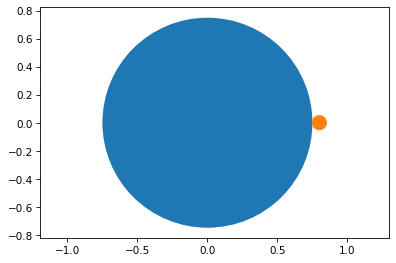

In [46]:
from matplotlib.patches import Circle
from matplotlib.pyplot import gca, axis

def draw_func(t, state):
    theta, omega = state

    # draw a circle for the table
    circle1 = Circle([0, 0], cents_circ)
    gca().add_patch(circle1)

    # draw a circle for the teapot
    center = pol2cart(theta, cents_pot)
    circle2 = Circle(center, 0.05, color='C1')
    gca().add_patch(circle2)

    axis('equal')
state = results.iloc[0]
draw_func(0, state)

Exercises

Exercise 1

In [47]:
system3 = system.set(torque_friction=actual_friction)
remaining_angle = theta_target - theta_test
remaining_angle

0.6415926535897931

In [53]:
def error_func2(force, system):
    results = run_two_phases(force, system.torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(force, theta_final)
    return theta_final - remaining_angle
guessa = 10
error_func2(guessa, system3)

10 4.9999920580880275


4.358399404498234

In [54]:
guessb = -10
error_func2(guessb, system3)

-10 -302.5977956570578


-303.2393883106476

In [55]:
res = root_scalar(error_func2, system3, bracket=[guessa, guessb])

10 4.9999920580880275
10.0 4.9999920580880275
-10.0 -302.5977956570578
9.71661698630067 4.858300776298656
1.398850399972888 -37.26966183192324
8.884067967646736 4.442026928174801
5.141459183809812 2.5707255086032825
3.27015479189135 1.635074798817526
2.3345025959321193 -15.490724276620016
3.2158768135772275 1.6079358527675578
2.7751897047546734 -5.232962828591856
3.1536254909934875 1.5768102409151394
2.9644075978740805 -0.8285861848019361
3.0800576168626512 1.5400263622766799
3.022232607368366 0.5173918146615879
3.0292555606872917 0.6808633080725421
3.0275684410098402 0.6415926535897866
3.0277198194328907 0.6451162505386082


In [56]:
force = res.root
results = run_two_phases(force, actual_friction, system3)
theta_final = results.iloc[-1].theta
print(theta_final + theta_test, theta_target)

3.1415926535897865 3.141592653589793
